# Implementacija Galjerkinove metode konačnih elemenata


### Uvod

U matematičkom modeliranju se često pojavljuje problem rješavanja parcijalnih diferencijalnih jednadžbi s rubnim uvjetom. Jako često te diferencijalne jednadžbe nije moguće riješiti analitičkim metodama, pa se moramo pouzdati u numeričke metode. Cilj ovog projekta je bio napraviti implementaciju metode konačnih elemenata koja riješava Poissonov problem:
$$ -\Delta u (x, y) = f(x, y)$$
S Dirichletovim rubnim uvjetima ($u(x,y) = 0$) na rubu domene oblika $[0, x_0] \times [0, y_0], \quad x_0, y_0 \in \mathbb{R}$


Poopćenja koja sam htio napraviti, ali nisam ih stigao implementirati su proširenje na proizvoljne rubne uvjete i odabir domene proizvoljnog oblika. Za prvo sam našao ideju za implementaciju u knjigi "Numerical Models for Differential Problems" Alfia Quarteronia, a za drugo sam smislio svoj algoritam (iako nisam provjeravao jel se itko prije sjetio toga, pa ne mogu sa 100% sigurnošću reći da je to moje). Obje ideje sam isprezentirao na kraju ove bilježnice.

### Poissonov problem i njegova slaba formulacija

Promatrajmo Poissonov problem s Dirichletovim uvjetima:
$$ - \Delta u(\textbf{x})= f(\textbf{x})$$
$$ \textbf{x} \in \Omega \subseteq \mathbb{R}^n, \; n \in \mathbb{N}$$

Vidimo da je ovo parcijalna diferencijalna jednadžba reda $2$, njezina slaba formulacija je $1$ reda i nalazi se u integralnom obliku. Nju ćemo dobiti tako da pomnožimo obje strane s testnom funkcijom $v$, i onda integriramo po domeni $\Omega$.
$$- \int_{\Omega}(\Delta u) v d\Omega = \int_{\Omega}f v d\Omega$$ 
Zatim koristimo poopćenje Newton-Leibnitzove formule za slučaj višedimenzionalne domene i dobijemo:
$$ \int_{\Omega} \nabla u \cdot \nabla v d\Omega - \int_{\partial \Omega} \nabla u \cdot \textbf{n}(\textbf{x}) v d\gamma = \int_{\Omega}f v d\Omega$$
Gdje je $\textbf{n}(\textbf{x})$ jedinični vektor normale na rub $\partial \Omega$ u točki $\textbf{x}$. 

Moć ovog pristupa proizlazi iz sljedećeg. Kao prvo, zbog Dirichletovih uvjeta možemo odabrati tesne funkcije koje su jednake $0$ na rubu intervala. Na taj način sada imamo:
$$ \int_{\Omega} \nabla u \cdot \nabla v d\Omega  = \int_{\Omega}f v d\Omega$$
Druga činjenica je da funkcija $f$ sada može poprimiti više različitih oblika. Naprimjer $f$ sada smije biti Dirac-delta funkcija. To omogućuje modeliranje raznih pojava iz fizikalnog svijeta kao što je djelovanje sile u nekoj točki ili širenje topline iz nekog točkastog izvora.
U ovom razmišljanju sam (radi jednostavnosti) izostavio puno stvari. Mi možemo reći da su ove dvije formulacije ekvivalentne ako derivacije u početnoj formulaciji shvatimo kao distribucijske derivacije, jednakost između $-\Delta u$ i $f$ shvatimo u vidu distribucija. To je detaljnije elaborirano u [1] na str. 43.

### Galjerkinov problem

Sljedeći korak je interpolirati funkciju s testnim funkcijama $\varphi_j$ odnosno:
$$ u_h(\textbf{x} = \sum_{j = 1}^{N_h} u_j \varphi_j\textbf{x} $$
Uvrštavanjem u slabu formulaciju (za neku testnu funkciju $\varphi_i$) dobijemo zbog aditivnosti integrala:
$$\sum_{j = 1}^{N_h} u_j \int_{\Omega} \nabla \varphi_j \cdot \nabla \varphi_i d\Omega  = \sum_{j = 1}^{N_h}  \int_{\Omega}f \varphi_j d\Omega $$
Sada se problem svodi na određivanje koeficienata $u_j$. Te koeficiente ćemo dobiti tako da zapišemo gornji izraz za sve $i$ od $1$ do $N_h$ i onda taj sustav zapišemo u matričnom obliku.
Dobijemo:
$$ \textbf{A} \textbf{u} = \textbf{b}$$
gdje je $a_{i,j} = \int_{\Omega} \nabla \varphi_j \cdot \nabla \varphi_i d \Omega$ i $b_i = \int_{\Omega}f \varphi_i d\Omega$.

Problem smo sveli na rješavanje linearnog sustava. Matricu $\textbf{A}$ često zovemo na engleskom "stiffness matrix".

Imamo samo još par stvari za razjasniti:

1. Pitanje jedinstvenosti rješenja je elaborirano u [1], ali ukratko potrebno je problem definirati preko bilinearne forme i onda koristiti Lax-Milgramov teorem o "invertiranju" bilinearne forme. 

2. Pitanje konvergencije $u_h$ prema $u$ je također elaborirano u [1], ali će se za razliku od jedinstvenosti jasno intuitivno vidjeti odmah u nastavku.



### Mesh i bazne funkcije

Domenu nad kojom ću rješavati zadani problem će biti podijeljena na trokute (koje zovemo elementi) jer ću rješavati problem u $2$ dimenzije (u nastavku će se vidjeti zašto baš trokute) kao sto se vidi na slici ispod.
![Alt Text](slike/Mesh.png)
Bazne funkcije ću definirati za svaki čvor (sjecišta rubova trokuta u meshu) tako da na svakom trokutu kojem je jedan od vrhova taj čvor definiram ravninu koja je "visine" $1$ iznad tog čvora i prolazi kroz ostale vrhove tog trokuta. Ovo se može bolje vidjeti na sljedećoj slici:
![Alt Text](slike/BaznaFja.png)

### Implementacija

Prvo je potrebno izgenerirati mesh.

In [1]:
import numpy as np
#Nx i Ny je broj čvorova po horiznotalnoj liniji, a Ny po vertikalnoj
#grid je brElem x 3 matrica
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as tri

def generateRectangleMesh(grid, Nx, Ny, h):
    nodeIndices = np.arange(Nx * Ny).reshape(Ny, Nx)
    
    edgeNodes = []
    edgeNodes.extend(nodeIndices[0, :])        
    edgeNodes.extend(nodeIndices[-1, :])      
    edgeNodes.extend(nodeIndices[1:-1, 0])    
    edgeNodes.extend(nodeIndices[1:-1, -1])   
    edgeNodes = list(set(edgeNodes))
    
    innerNodes = list(set(np.arange(Nx * Ny)) - set(edgeNodes))
    newOrder = innerNodes + edgeNodes
    indexMap = {old: new for new, old in enumerate(newOrder)}
    reverseIndexMap = {new: old for old, new in indexMap.items()}  
    elemNum = 0
    for yIndex in range(0, Ny - 1):
        pos = ((yIndex + 1) // 2) * 2 * Nx
        goingUp = (yIndex % 2 == 0)
        for xIndex in range(0, Nx - 1):
            nextPos = pos + (1 - Nx + 2 * Nx * goingUp)
            grid[elemNum][0] = indexMap[pos]
            grid[elemNum][1] = indexMap[nextPos]
            grid[elemNum][2] = indexMap[pos + 1]
            elemNum += 1
            grid[elemNum][0] = indexMap[nextPos]
            grid[elemNum][1] = indexMap[pos]
            grid[elemNum][2] = indexMap[nextPos - 1]
            elemNum += 1
            pos = nextPos
            goingUp = not goingUp
    
    return reverseIndexMap

def nodeToCoords(node, reverseIndexMap, Nx, h):
    originalNode = reverseIndexMap[node]
    return ((originalNode % Nx) * h, (originalNode // Nx) * h)


Mesh je spremljen unutar $N \times 3$ matrice. U kojoj su spremljeni redni brojevi čvorova koji sačinjavaju jedan element. Implementirano je da su čvorovi na rubu numerirani najvećim brojevima kako bi bilo lakše u nastavku baratati s njima. "nodeToCoords" funkcija služi za dobivanje koordinata čvora iz njegovog rednog broja.

In [2]:

#A je incijalizirana kao nul matrica
def createStifnesMat(A, grid, Nx, Ny, h, reverseIndexMap):
    elNum = (Nx - 1) * (Ny - 1) * 2
    gradPhi0 = np.array([-1, -1])
    gradPhi1 = np.array([1, 0])
    gradPhi2 = np.array([0, 1])
    limit = (Nx - 2) * (Ny - 2)
    for i in range(0, elNum):
        node0 = int(grid[i][0])
        node1 = int(grid[i][1])
        node2 = int(grid[i][2])
        xy0 = nodeToCoords(node0, reverseIndexMap, Nx, h)
        x0 = xy0[0]
        y0 = xy0[1]

        xy1 = nodeToCoords(node1, reverseIndexMap, Nx, h)
        x1 = xy1[0]
        y1 = xy1[1]

        xy2 = nodeToCoords(node2, reverseIndexMap, Nx, h)
        x2 = xy2[0]
        y2 = xy2[1]
        det = abs((x1 - x0) * (y2 - y0) - (x2 - x0) * (y1 - y0))
        Jc = np.array([[y2 - y0, y0 - y1], [x0 - x2, x1 - x0]])
        #0 i 1
        isEdge0 = node0 >= limit 
        isEdge1 = node1 >= limit
        isEdge2 = node2 >= limit 
        if ((not isEdge0) and (not isEdge1)):
            A[node0][node1] += np.dot(np.matmul(gradPhi0, Jc), np.matmul(gradPhi1, Jc)) / (2 * det) 
            A[node1][node0] += np.dot(np.matmul(gradPhi0, Jc), np.matmul(gradPhi1, Jc)) / (2 * det)

        #1 i 2
        if ((not isEdge1) and (not isEdge2)):
            A[node1][node2] += np.dot(np.matmul(gradPhi1, Jc), np.matmul(gradPhi2, Jc)) / (2 * det) 
            A[node2][node1] += np.dot(np.matmul(gradPhi1, Jc), np.matmul(gradPhi2, Jc)) / (2 * det)
        #0 i 2
        if ((not isEdge0) and (not isEdge2)):
            A[node0][node2] += np.dot(np.matmul(gradPhi0, Jc), np.matmul(gradPhi2, Jc)) / (2 * det) 
            A[node2][node0] += np.dot(np.matmul(gradPhi0, Jc), np.matmul(gradPhi2, Jc)) / (2 * det)
        #0 i 0
        if (not isEdge0):
            A[node0][node0] += np.dot(np.matmul(gradPhi0, Jc), np.matmul(gradPhi0, Jc)) / (2 * det) 
        #1 i 1
        if (not isEdge1):
            A[node1][node1] += np.dot(np.matmul(gradPhi1, Jc), np.matmul(gradPhi1, Jc)) / (2 * det) 
        #2 i 2
        if (not isEdge2):
            A[node2][node2] += (np.dot(np.matmul(gradPhi2, Jc), np.matmul(gradPhi2, Jc))) / (2 * det) 

Za matricu $\textbf{A}$ iteriram po svim elementima. Za neki element koji je sačinjen od vrhova numeriranih s $i,j,k$. Matricu $\textbf{A}$ koja je na početku inicijalizirana s nulama, ažuriramo tako da recimo $a_{i,j}$ dodamo vrijednost integrala $\int_K \nabla \phi_i \cdot \nabla \phi_j d \Omega$ gdje je $K$ oznaka za element na kojem integriramo. Ovakav pristup iteracije po elementima, a ne po čvorovima funkcionira zbog aditivnosti intgrala i opisan je detaljnije i [1] str. 190. tamo je također spomenuto kako je vremenski učinkovitiji zbog manje potrebe za "if else" naredbama. Izračun navedenog integrala se izvodi sljedećom zamjenom varijabli.
$$x = x_0 + (x_1 - x_0) \hat x + (x_2 - x_0) \hat y$$
$$y = y_0 + (y_1 - y_0) \hat x + (y_2 - y_0) \hat x$$
Na ovaj način smo domenu integriranja transformirali iz nekog generičkog trokuta u pravokutni trokut s vrhovima $(0,0), (1,0), (0,1)$. Na ovaj način smo integraciju učinili "programski prihvatljivijom", naime ovakav način integriranja je otporan na kompliciranije mesheve s trokutima raznih dimenzija. S obzirom da su u pitanju ravnine integrali su izračunati egzaktno, ali kada bi povećali stupanj polinoma baznih funkcija koristio bih Gaussove čvorove i utege za integraciju. Tako sam integrirao pri računanju slobodnog člana $\textbf{b}$.

In [3]:
def createFreeTerm(b, grid, Nx, Ny, h, f, reverseIndexMap):
    elNum = (Nx - 1) * (Ny - 1) * 2
    limit = (Nx - 2) * (Ny - 2)
    for i in range(0, elNum):
        node0 = int(grid[i][0])
        node1 = int(grid[i][1])
        node2 = int(grid[i][2])
        xy0 = nodeToCoords(node0, reverseIndexMap, Nx, h)
        x0 = xy0[0]
        y0 = xy0[1]

        xy1 = nodeToCoords(node1, reverseIndexMap, Nx, h)
        x1 = xy1[0]
        y1 = xy1[1]

        xy2 = nodeToCoords(node2, reverseIndexMap, Nx, h)
        x2 = xy2[0]
        y2 = xy2[1]


        det = abs((x1 - x0) * (y2 - y0) - (x2 - x0) * (y1 - y0))
        #lambda za transformaciju 
        transformX = lambda x, y: x0 + (x1 - x0) * x + (x2 - x0) * y
        transformY = lambda x, y: y0 + (y1 - y0) * x + (y2 - y0) * y
        gaussNodes = np.array([(0, 0, 1 / 3), (1, 0, 1 / 3), (0, 1, 1 / 3)])

        #0
        if (node0 >= limit):
            continue
        for xw, yw, w in gaussNodes: 
            xHat = transformX(xw, yw)
            yHat = transformY(xw, yw)
            b[node0] += w * (f(xHat, yHat)) * (1 - xHat - yHat) * det
        #1
        if (node1 >= limit):
            continue
        for xw, yw, w in gaussNodes: 
            xHat = transformX(xw, yw)
            yHat = transformY(xw, yw)
            b[node1] += w * (f(xHat, yHat)) * xHat * det
        #2
        if (node2 >= limit):
            continue
        for xw, yw, w in gaussNodes: 
            xHat = transformX(xw, yw)
            yHat = transformY(xw, yw)
            b[node2] += w *( f(xHat, yHat)) * yHat * det


Opet smo napravili istu zamijenu varijabli, a integracija (zbog proizvoljnosti funkcije $f$) mora biti obavljena numerički. To sam izveo preko Gaussovih čvorova za pravokutni trokut s vrhovima $(0,0), (1,0), (0,1)$. Koristio sam 3 čvora, za veću preciznost bih koristio naravno više. 
U nastavku ću testirati svoju implementaciju za:
$$ f(x,y) =- 2  \pi^2 \sin(\pi x) \sin(\pi y)$$
Lako se vidi da će egzaktno rješenje biti:
$$u(x,y) = sin(\pi x) \sin(\pi y)$$
Za koje očito vrijede Dirichletovi uvjeti na intervalu $[0,1] \times [0, 1]$. U nastavku se može vidjeti grafički prikaz egzaktnog rješenja. 

![Alt Text](slike/egzaktnoRješenje.png)

In [11]:
def f(x, y):
    #return np.exp(x**2)
    return  2 * (np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

Testirajmo sada kod za različite vrijednosti $N_x$. Što je veći $N_x$, to je finiji mesh.

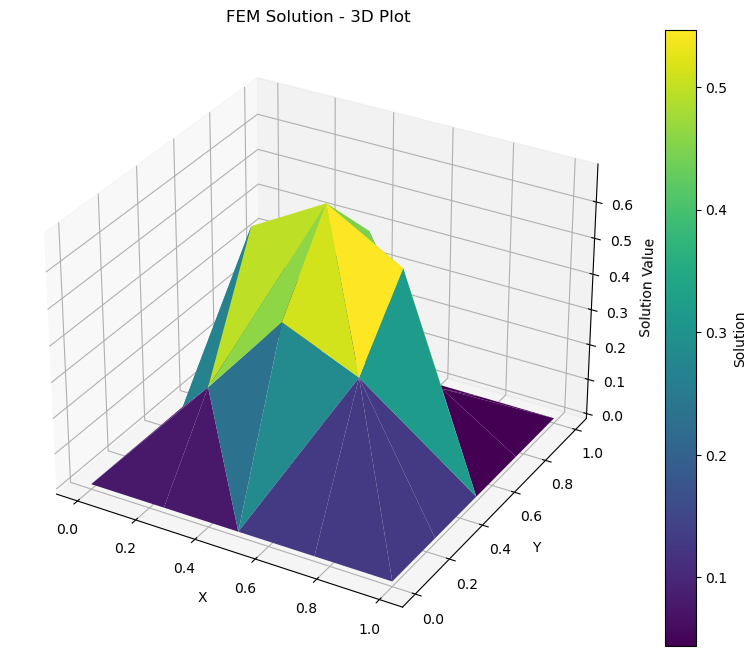

In [12]:
x0 = 1
y0 = 1
Nx = 5
h = x0 / (Nx - 1)
Ny = int((y0 / h) + 1)
nodeNum = Nx * Ny
elementNumber = (Nx - 1) * (Ny - 1) * 2
grid = np.zeros((elementNumber, 3))
reverseIndexMap = generateRectangleMesh(grid, Nx, Ny, h)
baseFooNum = (Nx - 2) * (Ny - 2)
#print(grid)
A = np.zeros((baseFooNum, baseFooNum))
createStifnesMat(A, grid, Nx, Ny, h, reverseIndexMap)
#print(A)
b = np.zeros(baseFooNum)
b = np.transpose(b)

createFreeTerm(b, grid, Nx, Ny, h, f, reverseIndexMap)
#print(b)
from numpy.linalg import solve
u = solve(A, b)
full_u = np.zeros(Nx * Ny)
for idx, value in enumerate(u):
    full_u[idx] = value
for i in range (nodeNum - 2 * Nx - 2 * Ny + 4,nodeNum):
    full_u[i] = 0


coordsX = []
coordsY = []
for i in range(0, nodeNum):
    x, y = nodeToCoords(i, reverseIndexMap, Nx, h)
    coordsX.append(x)
    coordsY.append(y)
x_coords = np.array(coordsX)
y_coords = np.array(coordsY)

triangles = grid.astype(int)
triangulation = tri.Triangulation(x_coords, y_coords, triangles)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(triangulation, full_u, cmap='viridis', edgecolor='none')

fig.colorbar(surf, ax=ax, label='Solution')

ax.set_title('FEM Solution - 3D Plot')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Solution Value')
plt.show()

Za $N_x = 10$ imamo:

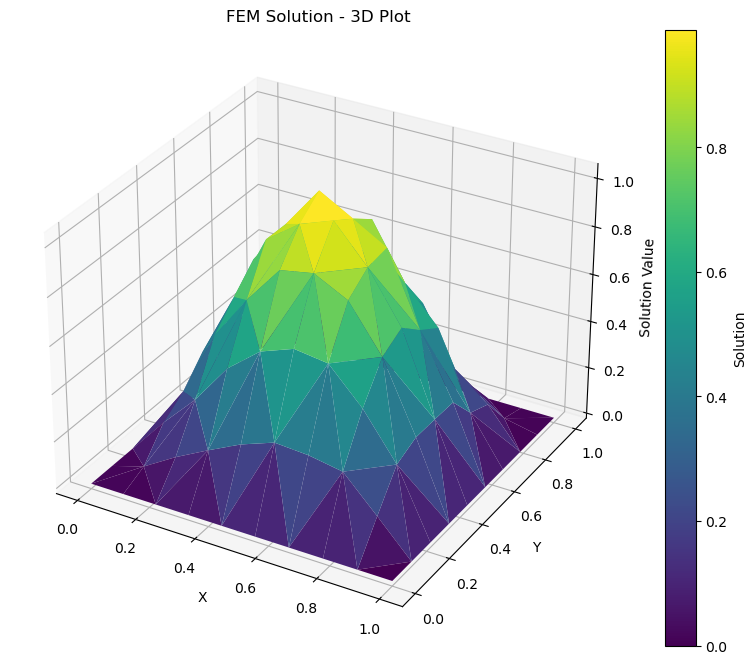

In [13]:
x0 = 1
y0 = 1
Nx = 10
h = x0 / (Nx - 1)
Ny = int((y0 / h) + 1)
nodeNum = Nx * Ny
elementNumber = (Nx - 1) * (Ny - 1) * 2
grid = np.zeros((elementNumber, 3))
reverseIndexMap = generateRectangleMesh(grid, Nx, Ny, h)
baseFooNum = (Nx - 2) * (Ny - 2)
#print(grid)
A = np.zeros((baseFooNum, baseFooNum))
createStifnesMat(A, grid, Nx, Ny, h, reverseIndexMap)
#print(A)
b = np.zeros(baseFooNum)
b = np.transpose(b)

createFreeTerm(b, grid, Nx, Ny, h, f, reverseIndexMap)
#print(b)
from numpy.linalg import solve
u = solve(A, b)
full_u = np.zeros(Nx * Ny)
for idx, value in enumerate(u):
    full_u[idx] = value
for i in range (nodeNum - 2 * Nx - 2 * Ny + 4,nodeNum):
    full_u[i] = 0


coordsX = []
coordsY = []
for i in range(0, nodeNum):
    x, y = nodeToCoords(i, reverseIndexMap, Nx, h)
    coordsX.append(x)
    coordsY.append(y)
x_coords = np.array(coordsX)
y_coords = np.array(coordsY)

triangles = grid.astype(int)
triangulation = tri.Triangulation(x_coords, y_coords, triangles)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(triangulation, full_u, cmap='viridis', edgecolor='none')

fig.colorbar(surf, ax=ax, label='Solution')

ax.set_title('FEM Solution - 3D Plot')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Solution Value')
plt.show()

Za $N_x = 30$ imamo:

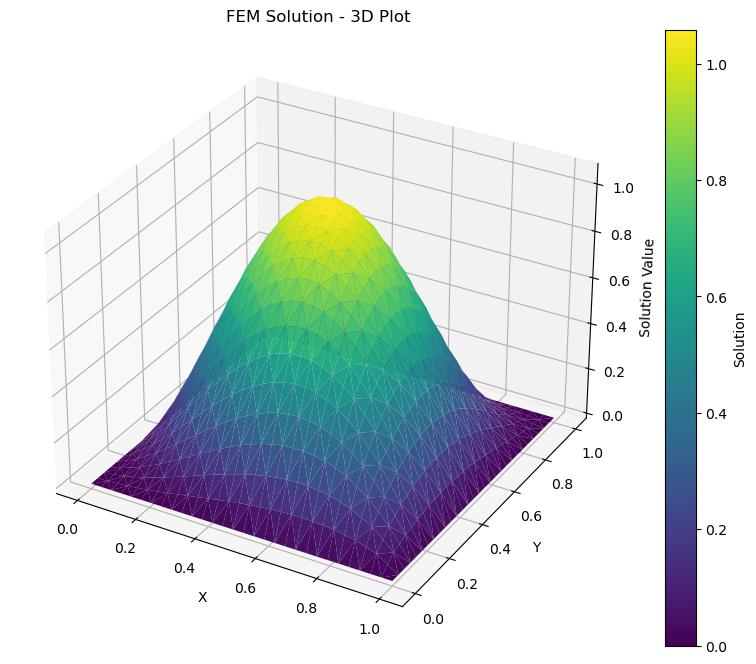

In [14]:

x0 = 1
y0 = 1
Nx = 30
h = x0 / (Nx - 1)
Ny = int((y0 / h) + 1)
nodeNum = Nx * Ny
elementNumber = (Nx - 1) * (Ny - 1) * 2
grid = np.zeros((elementNumber, 3))
reverseIndexMap = generateRectangleMesh(grid, Nx, Ny, h)
baseFooNum = (Nx - 2) * (Ny - 2)
#print(grid)
A = np.zeros((baseFooNum, baseFooNum))
createStifnesMat(A, grid, Nx, Ny, h, reverseIndexMap)
#print(A)
b = np.zeros(baseFooNum)
b = np.transpose(b)

createFreeTerm(b, grid, Nx, Ny, h, f, reverseIndexMap)
#print(b)
from numpy.linalg import solve
u = solve(A, b)
full_u = np.zeros(Nx * Ny)
for idx, value in enumerate(u):
    full_u[idx] = value
for i in range (nodeNum - 2 * Nx - 2 * Ny + 4,nodeNum):
    full_u[i] = 0


coordsX = []
coordsY = []
for i in range(0, nodeNum):
    x, y = nodeToCoords(i, reverseIndexMap, Nx, h)
    coordsX.append(x)
    coordsY.append(y)
x_coords = np.array(coordsX)
y_coords = np.array(coordsY)

triangles = grid.astype(int)
triangulation = tri.Triangulation(x_coords, y_coords, triangles)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(triangulation, full_u, cmap='viridis', edgecolor='none')

fig.colorbar(surf, ax=ax, label='Solution')

ax.set_title('FEM Solution - 3D Plot')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Solution Value')
plt.show()


Za $N_x = 50$ imamo:

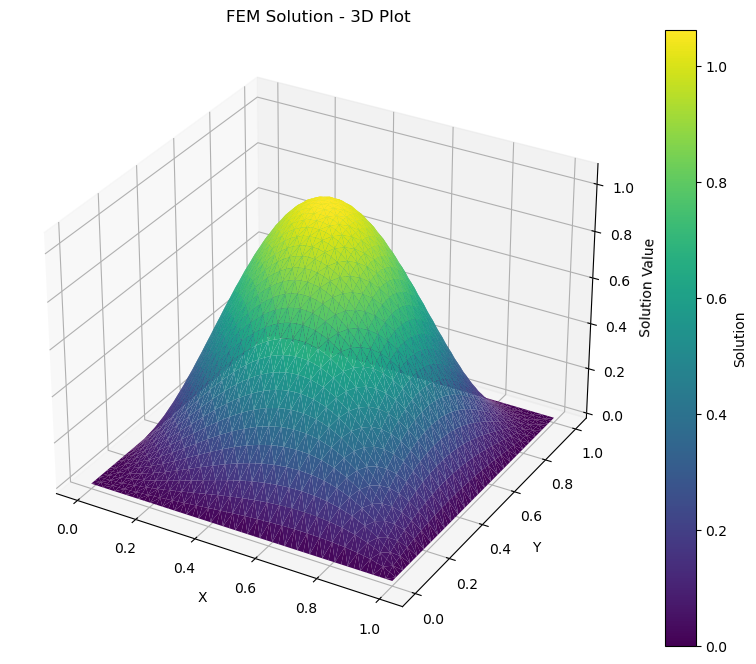

In [8]:
x0 = 1
y0 = 1
Nx = 50
h = x0 / (Nx - 1)
Ny = int((y0 / h) + 1)
nodeNum = Nx * Ny
elementNumber = (Nx - 1) * (Ny - 1) * 2
grid = np.zeros((elementNumber, 3))
reverseIndexMap = generateRectangleMesh(grid, Nx, Ny, h)
baseFooNum = (Nx - 2) * (Ny - 2)
#print(grid)
A = np.zeros((baseFooNum, baseFooNum))
createStifnesMat(A, grid, Nx, Ny, h, reverseIndexMap)
#print(A)
b = np.zeros(baseFooNum)
b = np.transpose(b)

createFreeTerm(b, grid, Nx, Ny, h, f, reverseIndexMap)
#print(b)
from numpy.linalg import solve
u = solve(A, b)
full_u = np.zeros(Nx * Ny)
for idx, value in enumerate(u):
    full_u[idx] = value
for i in range (nodeNum - 2 * Nx - 2 * Ny + 4,nodeNum):
    full_u[i] = 0


coordsX = []
coordsY = []
for i in range(0, nodeNum):
    x, y = nodeToCoords(i, reverseIndexMap, Nx, h)
    coordsX.append(x)
    coordsY.append(y)
x_coords = np.array(coordsX)
y_coords = np.array(coordsY)

triangles = grid.astype(int)
triangulation = tri.Triangulation(x_coords, y_coords, triangles)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(triangulation, full_u, cmap='viridis', edgecolor='none')

fig.colorbar(surf, ax=ax, label='Solution')

ax.set_title('FEM Solution - 3D Plot')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Solution Value')
plt.show()

Za $N_x = 100$ mu treba malo duže da izvrti program. Nadao sam se da ću moći tako pokazati značajnu numeričku grešku koja je događa zbog finijeg mesha, ali nažalost ili na sreću (ovisno o tome kako se gleda), da bi se vidjela takva numerička greške potrebno je napraviti još finiji mesh za koji bi programu trebalo predugo da izvrši program. Rezultat izvođenja je samo preciznije rješenje.

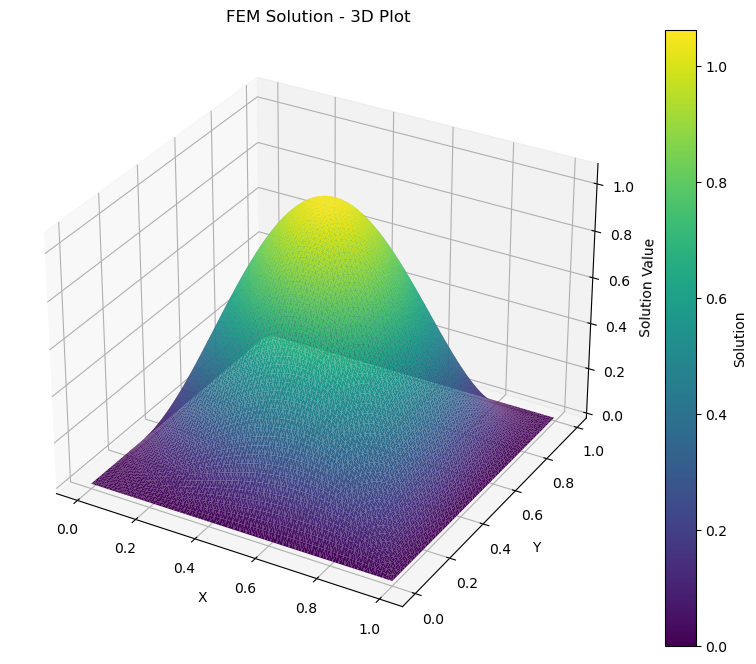

In [9]:
x0 = 1
y0 = 1
Nx = 100
h = x0 / (Nx - 1)
Ny = int((y0 / h) + 1)
nodeNum = Nx * Ny
elementNumber = (Nx - 1) * (Ny - 1) * 2
grid = np.zeros((elementNumber, 3))
reverseIndexMap = generateRectangleMesh(grid, Nx, Ny, h)
baseFooNum = (Nx - 2) * (Ny - 2)
#print(grid)
A = np.zeros((baseFooNum, baseFooNum))
createStifnesMat(A, grid, Nx, Ny, h, reverseIndexMap)
#print(A)
b = np.zeros(baseFooNum)
b = np.transpose(b)

createFreeTerm(b, grid, Nx, Ny, h, f, reverseIndexMap)
#print(b)
from numpy.linalg import solve
u = solve(A, b)
full_u = np.zeros(Nx * Ny)
for idx, value in enumerate(u):
    full_u[idx] = value
for i in range (nodeNum - 2 * Nx - 2 * Ny + 4,nodeNum):
    full_u[i] = 0


coordsX = []
coordsY = []
for i in range(0, nodeNum):
    x, y = nodeToCoords(i, reverseIndexMap, Nx, h)
    coordsX.append(x)
    coordsY.append(y)
x_coords = np.array(coordsX)
y_coords = np.array(coordsY)

triangles = grid.astype(int)
triangulation = tri.Triangulation(x_coords, y_coords, triangles)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(triangulation, full_u, cmap='viridis', edgecolor='none')

fig.colorbar(surf, ax=ax, label='Solution')

ax.set_title('FEM Solution - 3D Plot')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Solution Value')
plt.show()

### Problem proizvoljnog rubnog uvjeta

### Problem domene proizvoljnog oblika

Problem domene prozvoljnog oblika je ustvari samo problem konstrukcije mesha za neki proizvoljan oblik. Takav proizvoljan oblik u računalu mogu aproksimativno predstaviti kao listu koordinata $[(x_i,y_i)]$ koja predstavlja vrhove nekog mnogokuta poredanih redom (radi lakšeg objašnjavanja algoritma u nastavku pretpostavimo da su one poredane u smjeru kazaljke na satu). Ako bi korisnik htio da mu domena bude zakrivljenog oblika, morao bi tu domenu aproksimirati s mnogokutom s više točaka. Zaključio sam da je ovakva aproksimacija jednostavno neizbježna jer radim s trokutima, a i da radim hipotetski s nekim kompliciranijim oblicima u računalo ne mogu uvijek točno reprezentirati neku krivulju.

Sada kada imamo mnogokut programu dajemo neku float vrijednost $h$ koja predstavlja nekakav okvirni razmak između dva susjedna čvora mesha. Sada konstruiramo mesh izvana prema unutra tako da idemo u krug po točkama unutarnje granice trenutno konstruiranog mesha (taj mesh je na početku samo lista točaka koja definira mnogokut) i za svake dvije susjedne točke (na toj trenutno promatranoj granici) imamo $3$ slučaja.
1. dvije točke su udaljene za više od $2h$ jedna od druge
2. dvije točke su udaljene za manje od$\frac{1}{2}h$ jedna od druge
3. inače
U $1.$ slučaju ubacujemo novu točku na polovište između te dvije točke i krećemo opet s istom provjerom krečući od prve točke. Prva točka je ona koja se pojavljuje u listi prije druge (zanemarujući rubni slučaj točke na kraju liste) odnosno prva točka je ona koju bi prvu susreli ako bi se kretali po mnogokutu u smjeru kazaljke na satu (pod pretpostavkom da nismo krenuli putovanje iz druge točke, onda bi očito prvo susreli drugu točku)

U $2.$ slučaju brišem drugu točku i krećem opet s istom provjerom s početkom u prvoj točki

U $3.$ slučaju samo prelazim na drugu točku.

Sada kada smo izgenerirali jedan sloj mesha stvaramo novi sloj tako da svaku točku u unutarnjem sloju trenutno izgeneriranog mesha pomaknemo za $h$ prema težištu tog unutarnjeg sloja. Ovo se može napraviti kao kombinacija translacije i linearne trasformacije skaliranja. I sada ponavljamo taj postupak sve dok se novi izgenerirani sloj sastoji od više od $3$ točke. Pri konstrukciji tih točaka bilježimo veze između njih i mapu za prijelaz u koordinate. 

### Usporedba s metodom konačnih diferencija

### Reference

[1] Alfio Quarteroni